In [1]:
import matplotlib.pyplot as plt
import nltk
import re
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from itertools import chain
from nltk.corpus import inaugural
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# set seaborn settings
sns.set(font='serif', style='whitegrid')

# define colors for war and peace
color_peace ="#2ecc71"
color_war = "#e74c3c"

In [3]:
# load spacy model
nlp = spacy.load("en_core_web_sm")

The outline of this notebook follows the Cross-Industry Standard Process for Data Mining (CRISP-DM)

### Business Understanding
The objective of this notebook is to analyze the **inaugural address corpus**. For this I will formulate three questions, which will help to understand some key characteristics of the dataset and hopefully lead to further discussions. The formulated questions are:
- *What are some common topics in the speeches?* 
- *How important were war and peace over time?*
- *What were important words during war and peace peaks?*

### Data Understanding
The inaugural address corpus contains inauguration speeches of former presidents from the USA and can be easily accessed via the `nltk` package. Even though it is possible to retrieve already tokenized documents I will load the raw text of the speeches and tokenize them later on. 

In [4]:
# load speech texts
president_speeches = [inaugural.raw(fileid) for fileid in inaugural.fileids()]

To check if everything worked like expected we can take a look at how many characters the speeches have. This helps us to verify that every speech contains text and is not empty. The following plot shows the number of characters on the x-axis and the frequency of speeches on the y-axis.

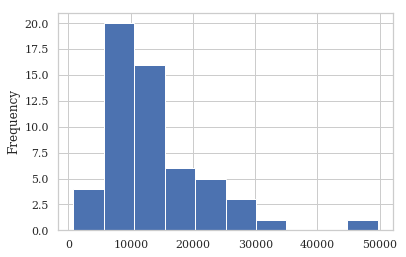

In [5]:
pd.Series([len(speech) for speech in president_speeches]).plot(kind='hist');

We can see that the number of characters varies quite a lot depending on the speech. Let's check how many characters the shortest speech has to ensure that there are no speeches with no text at all.

In [6]:
pd.Series([len(speech) for speech in president_speeches]).min()

791

Very good. The shortest speech has 791 characters and we can therefore be sure that all the speeches contain some information.

### Prepare Data
Usually in this step it is also necessary to impute missing values. In this dataset however, there are no missing values.

In order to later analyze the speeches it is necessary to transform the text in a suitable representation. Since we are especially interested in the topics the presidents have spoken about in the past, we have to extract them first. 

To keep things simple we say **as soon as a word is a noun it is considered a topic** which of course is not always true but it is a good first step. We extract all the nouns in the corpus with the `extract_topics` function which uses spacy's Part of Speech Tagger and we further lemmatize and lower the retrieved nouns to improve generalization. 

In [7]:
def extract_topics(text):
    """extracts topics/nouns from raw text input
    Args:
        text (string): plain text
    Returns:
        token_list (list): a list of the found topics/nouns
    """
    doc = nlp(text)
    token_list = []
    for sent in doc.sents:
        for tok in sent:
            if not tok.is_stop and tok.pos_ == 'NOUN':
                # lemma and lower the noun
                token_list.append(tok.lemma_.lower())
    return token_list

In [8]:
# extract topics
president_topics = [extract_topics(speech) for speech in president_speeches]

To compare the speeches we have to transform the topics of the speeches into numbers. With the `TfidfVectorizer` method we create the term frequency-inverse document frequency for the topics of the speeches. This representation gives topics which are decisive to a speech a higher score and therefore resembles the importance of the term to the document. 

The `create_tfidf` method creates this representation respectively.

In [9]:
def create_tfidf(president_topics):
    """transforms the tokenized topics/nouns into a tfidf representation
    Args:
        president_topics (list of lists): tokenized documents (speeches with topics/nouns) 
    Returns:
        tfidf_df (dataframe): columns are the years of the speeches, rows are the vocabulary of the corpus
    """""
  # lambda ensures that the input is not tokenizedcy
    count = TfidfVectorizer(analyzer=lambda x:x)
    bag_of_words = count.fit_transform(president_topics)
    feature_names = count.get_feature_names()
    tfidf_df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names).T
  # change columns to just the yearsrs
    tfidf_df.columns = [fieldid[:4] for fieldid in inaugural.fileids()]
    return tfidf_df

In [10]:
# create tfidf dataframe
tfidf_df = create_tfidf(president_topics)

### Data Analyzation
Strictly following the CRISP-DM this would be the modeling step but for this project it is a deeper analyzation step which tries to answer the formulated questions. In this section I will once again name the questions and additionally provide visualizations which try to answer the questions. 

 #### What are some common topics in the speeches?
 The function `plot_most_frequent_nouns` identifies some of the most frequent nouns in the corpus. This will be helpful to get a sense about what the presidents in the past have talked about.  

In [11]:
# plots the N most frequent nouns
def plot_most_frequent_nouns(president_topics, TOP_N):
    """plots the N most frequent topics/nouns in the corpus
    Args:
        president_topics (list of lists): tokenized documents (speeches with topics/nouns) 
        TOP_N (int): number of topics/nouns to consider  
    Returns:
        the corresponding frequency plot
    """
    freq_dist = nltk.FreqDist(chain.from_iterable(president_topics))
    aspects, values = zip(*freq_dist.most_common()[:TOP_N])
    fig, ax = plt.subplots(figsize=(10,8))
    color_list = list(np.repeat('gray',15))
    # set colors for war and peace
    color_list[9] = color_peace
    color_list[14] = color_war
    ax.barh(list(aspects), list(values),color=color_list)
    ax.set_xlabel('Frequency')
    ax.set_title('Most common nouns/topics')
    fig.tight_layout()

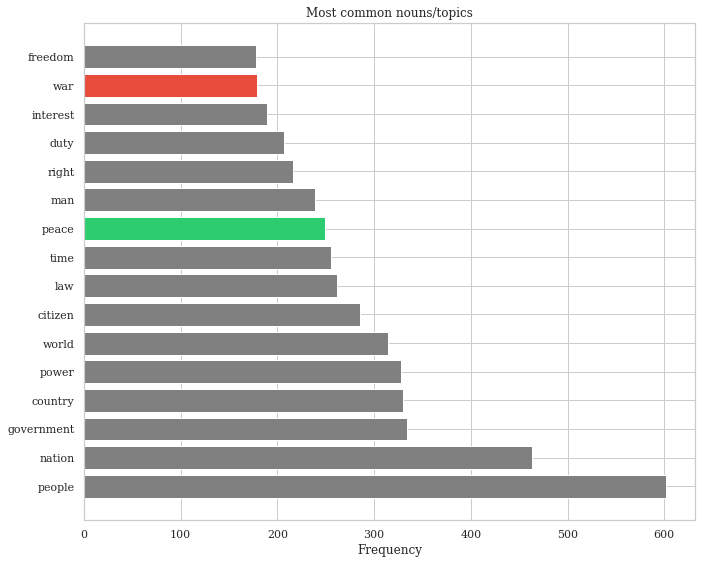

In [12]:
plot_most_frequent_nouns(president_topics, TOP_N=16)

#### How important were war and peace over time?
The function `plot_war_and_peace_time` will further explore how the importance of two of the identified topics/nouns (*war and peace*) has changed over time. 

In [13]:
def plot_war_and_peace_time(tfidf_df):
    """plots the nouns 'war' and 'peace' and their tfidf score over time
    Args:
        tfidf_df (dataframe): a tfidf dataframe 
    Returns:
        the corresponding timeline plot
    """
    fig, ax = plt.subplots(figsize=(13,5))
    ax.plot(tfidf_df.loc['war',:], color=color_war)
    ax.plot(tfidf_df.loc['peace',:], color=color_peace)
    ax.legend()
    ax.set_ylabel('TfIdf Score')
    ax.annotate('War of 1812', xy=('1817', 0.35))
    ax.annotate('American Civil War', xy=('1869', 0.37))
    #ax.annotate('World War I', xy=('1909', 0.18))
    ax.annotate('World War II', xy=('1937', 0.22))
    ax.annotate('Vietnam War', xy=('1965', 0.35))
    ax.legend(title='Noun', shadow=True, fancybox=True)
    ax.set_title('Importance of war and peace over time')
    plt.xticks(rotation=45)
    fig.tight_layout()

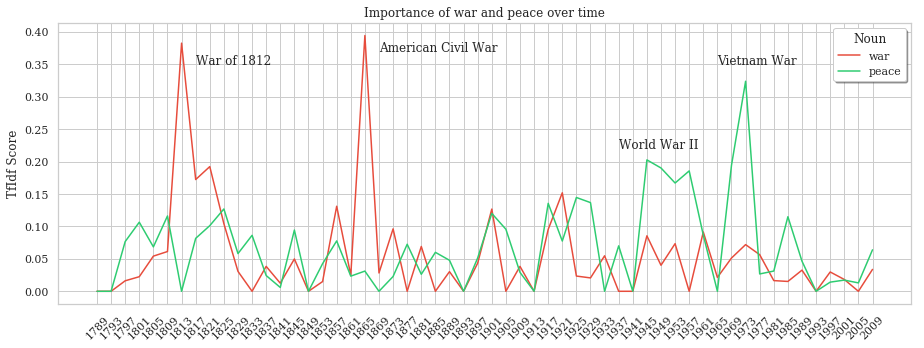

In [14]:
plot_war_and_peace_time(tfidf_df)

#### What were important words during war and peace peaks?
The function `plot_words_peek_years` analyzes the found high points even further and plots the most important words of the corresponding speeches.

In [16]:
# plot the top N words (tfidf) for the four peak points
def plot_words_peek_years(tfidf_df, TOP_N):
    """plots the top N words (tfidf) for the four identified peak speeches
    Args:
        tfidf_df (dataframe): a tfidf dataframe 
        TOP_N (int): number of words to consider for one speech
    Returns:
        the corresponding timeline plot
    """
    president_list = ['Madison', 'Lincoln', 'Eisenhower','Nixon']
    year_list = [1813, 1865, 1957, 1973]
    color_list = [color_war, color_war, color_peace, color_peace]
    row_ind = [0,0,1,1]
    col_ind = [0,1,0,1]
    fig, ax = plt.subplots(figsize=(10,8), ncols=2,nrows=2, sharex=True)
    fig.suptitle('Most important nouns/topics for peak speeches')
    for president, year, color, i, j in zip(president_list, year_list, 
                                            color_list, row_ind, col_ind):
        # top words with corresponding tfidf
        d = tfidf_df.loc[:,str(year)].sort_values(ascending=False).reset_index()[:TOP_N]
        ax[i,j].barh(d.iloc[:,0],d.iloc[:,1],color=color)
        ax[i,j].set_title(f'{president} {year}')
    ax[1,1].set_xlabel('tfidf score')
    ax[1,0].set_xlabel('tfidf score')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

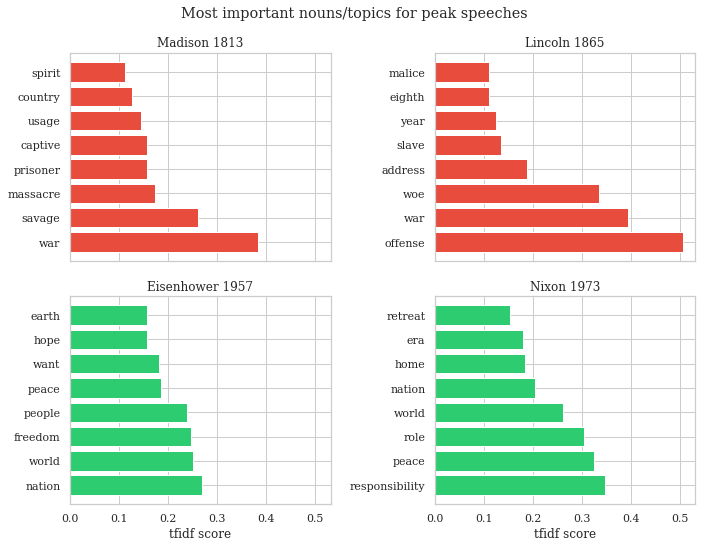

In [17]:
plot_words_peek_years(tfidf_df, TOP_N=8)

### Evaluate the results
The last step is to evaluate the results of the plots. A detailed evaluation of the plots can be found at https://pirnerjonas.github.io/2020/04/07/war-and-peace.html